In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from calcwf import *

In [2]:
sample_rate = 4096

In [17]:
def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd, _ = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssf/ss)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

# General functions

In [86]:
def calc_h1_h0(h, n, f_low, e, M, q, approximant='TEOBResumS'):

    # Generate and match fiducial wfs
    all_wfs = list(get_h([1]*n, f_low, e, M, q, sample_rate, approximant=approximant))
    match_cplx = match_hn(all_wfs[1:n+1], h, f_low)

    return abs(match_cplx[1])/abs(match_cplx[0])

In [87]:
def minimise_h1_h0_zero_ecc(h, n, f_low, q, approximant='TEOBResumS'):

    # Minimise h1/h0 by varying total mass
    start = time.time()
    print('Initialising minimisation at zero eccentricity.')
    init_guess = 60
    max_result = minimize(lambda x: calc_h1_h0(h, n, f_low, 0, x[0], q, approximant=approximant), init_guess)
    min_M = max_result['x']
    end = time.time()
    print(f'Minimisation complete after {end-start} seconds.')
    print(max_result)

    return min_M

In [88]:
def plot_h1_h0_zero_ecc(data_e, data_M, min_M, f_low, q):

    # Convert total mass to chirp mass
    data_chirp = total2chirp(data_M, q)
    min_chirp = total2chirp(min_M, q)

    # Get degeneracy line
    e_vals = np.linspace(0, 2*data_e, 101)
    chirp_vals = favata_et_al_avg(0, min_chirp, e_vals, f_low=f_low, q=q)

    # Plot
    plt.plot(chirp_vals, e_vals**2, c='k', ls='dashed', alpha=0.7, label='Degeneracy line')
    plt.scatter(min_chirp, 0**2, label='Minimised h2/h1, $e=0$')
    plt.scatter(data_chirp, data_e**2, label='Data waveform')

    # Plot formatting
    plt.xlabel('Chirp mass')
    plt.ylabel('$e_{10}^2$')
    plt.legend()

# Zero eccentricity tests

In [89]:
h_0 = gen_wf(10, 0.1, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS')
min_M_0 = minimise_h1_h0_zero_ecc(h_0, 4, 10, 2)

Initialising minimisation at zero eccentricity.
Minimisation complete after 111.62774729728699 seconds.
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.025873897005776417
        x: [ 6.000e+01]
      nit: 2
      jac: [ 2.946e+04]
 hess_inv: [[ 1.324e-15]]
     nfev: 167
     njev: 75


Average frequency: 29.732774931303208 Hz
Given_e shifted from 0 to 0.0


/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


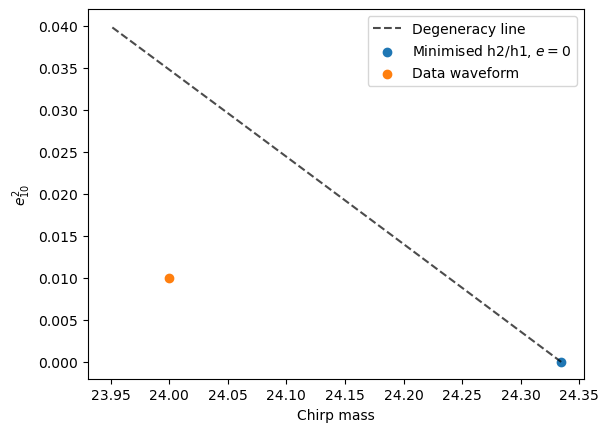

In [90]:
plot_h1_h0_zero_ecc(0.1, chirp2total(24, 2), min_M_0, 10, 2)